# Tutorial for simulating spatial transcriptomics data

We will demonstrate how to simulate spatial transcriptomics data with spatially varying correlation

## Import dependencies

In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
from anndata import AnnData
import importlib
import sys
from statsmodels.stats.multitest import multipletests, fdrcorrection
import json
import nest_asyncio

from simulate_spatial import normalize_deviance_residuals as ndr
from simulate_spatial import simulate_data as sd
from simulate_spatial import plot_spatial as ps

from collections import defaultdict

nest_asyncio.apply()

## Define functions we want to use throughout the notebook

In [2]:
def plot_gene(
        gene, 
        adata, 
        row_key='array_row', 
        col_key='array_col'
    ):
    ind = list(adata.var.index).index(gene)
    expr = X_res[:,ind]
    ps.plot_slide(
        adata.obs, 
        expr, 
        cmap='viridis', 
        #title="UMI count < 2,000",
        dsize=10,
        row_key=row_key,
        col_key=col_key
    )
    plt.title(gene)
    plt.show()
    


## Download a breast cancer dataset from 10x genomics

We're going to use this dataset as a "scaffold" from which to simulate data with known, spatially varying correlation

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Download data
adata_raw = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")
adata_raw.X = np.array(adata_raw.X.todense())
adata_raw.X = adata_raw.X.astype(np.int32)

# Filter spots
sc.pp.filter_cells(adata_raw, min_counts=5000)
sc.pp.filter_cells(adata_raw, max_counts=35000)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Let's take a  look at the image of the slide

... storing 'feature_types' as categorical
... storing 'genome' as categorical


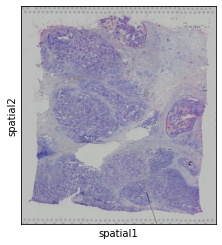

In [4]:
sc.pl.spatial(adata_raw, alpha=0.0)

## Normalize countes using deviance residuals

In [7]:
X_res = ndr.normalize(adata_raw.X)
expr_res_df = pd.DataFrame(
    data=X_res,
    index=adata_raw.obs.index,
    columns=adata_raw.var.index
)

# Build the new AnnData object
adata = AnnData(expr_res_df)
adata.obs = adata_raw.obs

expr_res_df

/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/normalize_deviance_residuals.py:28: RuntimeWarning: invalid value encountered in true_divide
  square = np.nan_to_num(2*X*np.log(X/M), copy=True, nan=0.0) \
/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/normalize_deviance_residuals.py:28: RuntimeWarning: divide by zero encountered in log
  square = np.nan_to_num(2*X*np.log(X/M), copy=True, nan=0.0) \
/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/normalize_deviance_residuals.py:28: RuntimeWarning: invalid value encountered in multiply
  square = np.nan_to_num(2*X*np.log(X/M), copy=True, nan=0.0) \
/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/normalize_deviance_residuals.py:36: RuntimeWarning: invalid value encountered in sqrt
  R = np.nan_to_num(np.sign(X - M) * np.sqrt(square), copy=True, nan=0.0)
Variable names are not unique. 

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,-0.181208,0.0,0.0,-0.021209,0.0,-0.067068,0.0,...,0.0,0.0,-0.021209,0.0,0.0,0.0,0.0,0.0,-0.588905,-0.190879
AAACAGGGTCTATATT-1,0.0,0.0,0.0,-0.248206,0.0,0.0,-0.029050,0.0,-0.091865,0.0,...,0.0,0.0,-0.029050,0.0,0.0,0.0,0.0,0.0,-0.806640,-0.261453
AAACATTTCCCGGATT-1,0.0,0.0,0.0,2.145119,0.0,0.0,-0.032391,0.0,-0.102428,0.0,...,0.0,0.0,-0.032391,0.0,0.0,0.0,0.0,0.0,-0.899391,-0.291516
AAACCCGAACGAAATC-1,0.0,0.0,0.0,-0.255385,0.0,0.0,-0.029891,0.0,-0.094522,0.0,...,0.0,0.0,-0.029891,0.0,0.0,0.0,0.0,0.0,1.930051,-0.269015
AAACCTAAGCAGCCGG-1,0.0,0.0,0.0,-0.306562,0.0,0.0,-0.035880,0.0,-0.113464,0.0,...,0.0,0.0,-0.035880,0.0,0.0,0.0,0.0,0.0,-0.996290,-0.322924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,-0.228069,0.0,0.0,-0.026693,0.0,-0.084412,0.0,...,0.0,0.0,-0.026693,0.0,0.0,0.0,0.0,0.0,1.064735,-0.240241
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,-0.237573,0.0,0.0,-0.027806,0.0,-0.087930,0.0,...,0.0,0.0,-0.027806,0.0,0.0,0.0,0.0,0.0,-0.772084,-0.250253
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,-0.299897,0.0,0.0,-0.035100,0.0,-0.110997,0.0,...,0.0,0.0,-0.035100,0.0,0.0,0.0,0.0,0.0,-0.974630,-0.315903
TTGTTTCCATACAACT-1,0.0,0.0,0.0,-0.225110,0.0,0.0,-0.026347,0.0,-0.083317,0.0,...,0.0,0.0,-0.026347,0.0,0.0,0.0,0.0,0.0,-0.731580,-0.237124


## Plot the expression of a few genes across the slide

This is just a sanity check that we've loaded the data correctly

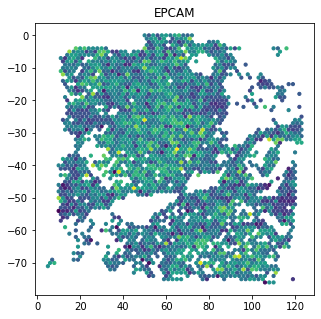

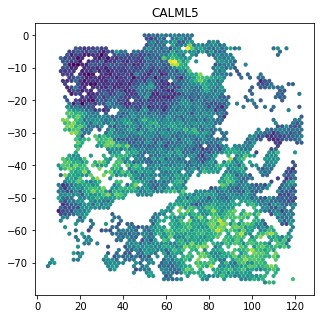

In [8]:
importlib.reload(ps)
plot_gene('EPCAM', adata)
plot_gene('CALML5', adata)

## Simulate a dataset based on this real dataset

In [9]:
importlib.reload(sd)

corr_mean = 0      # <- Set the mean correlation across the slide to zero
gene_1 = 'EPCAM'   # <- Set the mean of the first gene to be the mean of EPCAM
gene_2 = 'CALML5'  # <- Set the mean of the second gene to be CALML5
sigma = 10         # <- Set the Gaussian kernel width. The larger this value, the larger the spatial structure
cov_strength = 0.2

corrs, covs, adata_sim = sd.simulate_pairwise_from_dataset(
    adata,
    corr_mean, 
    gene_1,
    gene_2,
    row_key='array_row',
    col_key='array_col',
    sigma=sigma,
    cov_strength=cov_strength,
    poisson=False,
    size_factors=None
)

## Let's plot the simulated expression values across the slide for each gene

Notice how there are no clear expression patterns for either gene

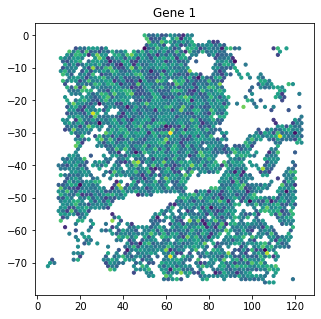

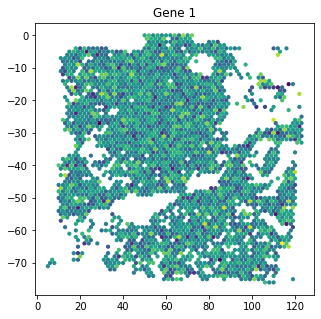

In [10]:
ps.plot_slide(
    adata.obs, 
    adata_sim.X.T[0], 
    cmap='viridis', 
    dsize=10,
    title='Gene 1',
    row_key='array_row',
    col_key='array_col'
)

ps.plot_slide(
    adata.obs, 
    adata_sim.X.T[1], 
    cmap='viridis', 
    dsize=10,
    title='Gene 1',
    row_key='array_row',
    col_key='array_col'
)

## Let's plot their true underlying correlations at each spot

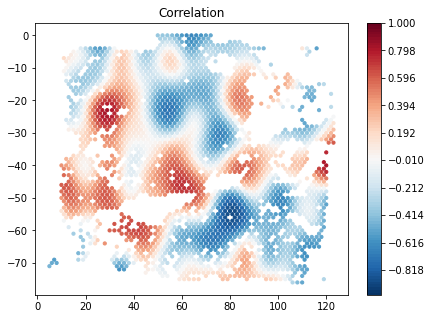

In [11]:
ps.plot_slide(
    adata.obs, 
    corrs, 
    cmap='RdBu_r', 
    dsize=10,
    colorbar=True,
    vmin=-1,
    vmax=1,
    title='Correlation',
    row_key='array_row',
    col_key='array_col'
)

## Let's play around with the parameters of this simulation

### First, let's vary `sigma`. We'll see that as `sigma` increases, the correlation patterns become more coarse

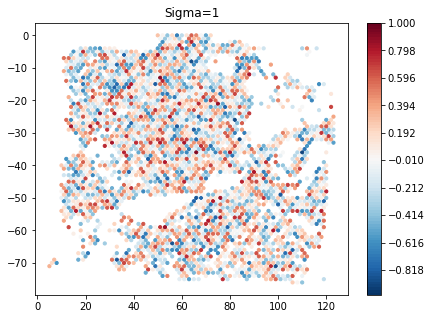

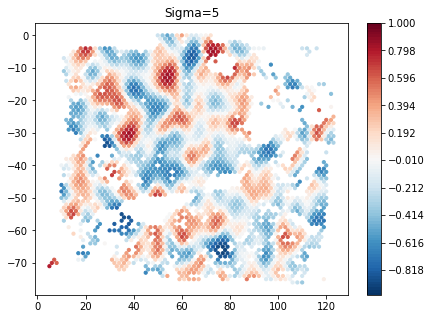

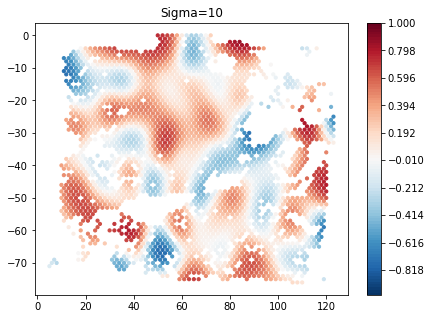

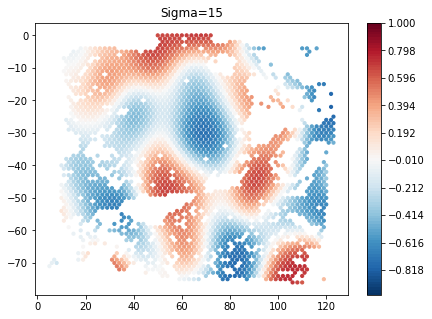

In [12]:
for sigma in [1, 5, 10, 15]:
    corrs, covs, adata_sim = sd.simulate_pairwise_from_dataset(
        adata,
        corr_mean, 
        gene_1,
        gene_2,
        row_key='array_row',
        col_key='array_col',
        sigma=sigma,
        cov_strength=0.2,
        poisson=False,
        size_factors=None
    )
    ps.plot_slide(
        adata.obs, 
        corrs, 
        cmap='RdBu_r', 
        dsize=10,
        colorbar=True,
        vmin=-1,
        vmax=1,
        title=f'Sigma={sigma}',
        row_key='array_row',
        col_key='array_col'
    )
    plt.show()

### Now let's vary `cov_strength`. We'll see that as `cov_strength` increases, the correlation magnitudes become larger

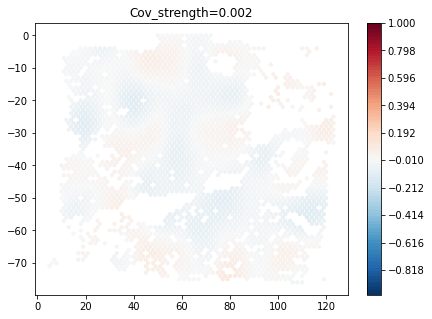

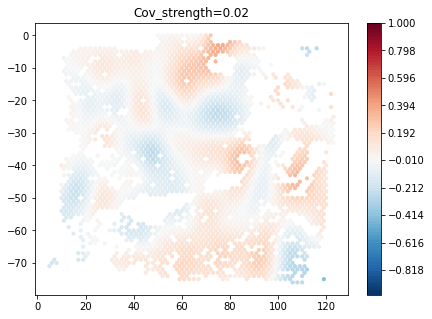

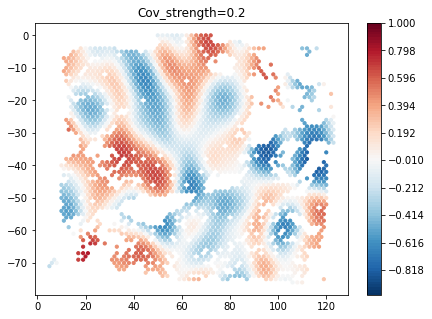

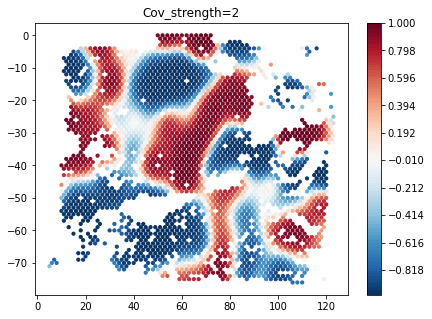

/Users/matthewbernstein/Development/spatial-transcriptomics-simulator/simulate_spatial/simulate_data.py:510: RuntimeWarning: covariance is not positive-semidefinite.
  lamb_s = np.random.multivariate_normal(spot_means, cov_mat)


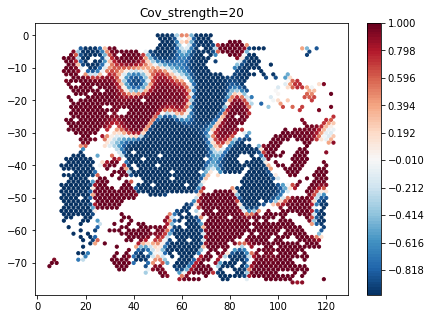

In [13]:
for cov_strength in [0.002, 0.02, 0.2, 2, 20]:
    corrs, covs, adata_sim = sd.simulate_pairwise_from_dataset(
        adata,
        corr_mean, 
        gene_1,
        gene_2,
        row_key='array_row',
        col_key='array_col',
        sigma=10,
        cov_strength=cov_strength,
        poisson=False,
        size_factors=None
    )
    ps.plot_slide(
        adata.obs, 
        corrs, 
        cmap='RdBu_r', 
        dsize=10,
        colorbar=True,
        vmin=-1,
        vmax=1,
        title=f'Cov_strength={cov_strength}',
        row_key='array_row',
        col_key='array_col'
    )
    plt.show()

## Simulate counts via the Poisson-lognormal model

Now we will simulate counts from the Poisson-lognormal-based model. Note, we pass in `True` for the `poisson` argument, and we pass in the total UMI counts for each cell to the `size_factors` argument. 

Note, the `size_factors` argument is expecting a NxG matrix where N is the number of spots and G is the number of genes. For spot i, gene j, the element at (i,j) is the size-factor to use at spot i for the jth gene. In this example, we simply use the total UMI counts from the real data at each spot for the size factors. Thus the size-factors for both genes at spot i will simply be the total UMI count at spot i in the experimental data (i.e., each row of the matrix consists of two identical values).

In [17]:
# Compute the size-factors matrix
umi_counts = np.array([
    np.sum(adata_raw.X, axis=1),
    np.sum(adata_raw.X, axis=1)
]).astype(np.int32).T    

In [15]:
corrs, covs, adata_sim = sd.simulate_pairwise_from_dataset(
    adata_raw,
    corr_mean, 
    gene_1,
    gene_2,
    row_key='array_row',
    col_key='array_col',
    sigma=sigma,
    cov_strength=0.2,
    poisson=True,
    size_factors=umi_counts
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Building...



Building: found in cache, done.Messages from stanc:
Warning at '/var/folders/rn/ls4vfc7x01d0zb_qrf70f43w0000gn/T/httpstan_dnkczis5/model_hvzhpnl3.stan', line 16, column 19 to column 21:
  Argument 20 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:  

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/rn/ls4vfc7x01d0zb_qrf70f43w0000gn/T/httpstan_jzukeni4/model_hvzhpnl3.stan', line 17, column 4 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Mu: [[-8.76846039 -8.78669004 -8.80193571 ... -8.78019988 -8.79388663
  -8.78955748]]
Sigma: [[0.33649317 0.35181517 0.31805526 ... 0.33986932 0.3129898  0.34521592]]
Building...



Building: found in cache, done.Messages from stanc:
Warning at '/var/folders/rn/ls4vfc7x01d0zb_qrf70f43w0000gn/T/httpstan_dnkczis5/model_hvzhpnl3.stan', line 16, column 19 to column 21:
  Argument 20 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:   0% (4/8000)
Sampling:  

Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  98% (7800/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
Sampling:  99% (7900/8000)
S

Mu: [[-6.7348736  -6.74606582 -6.75801297 ... -6.72483527 -6.72469629
  -6.74318394]]
Sigma: [[0.51961031 0.53165422 0.50818807 ... 0.52926516 0.51694871 0.5224605 ]]


Let's compare the distribution of the counts for the real data versus the simulated data

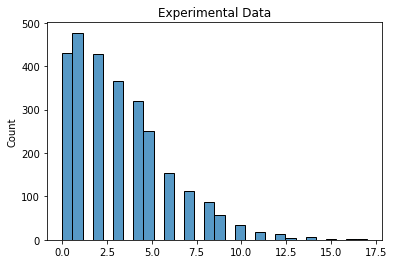

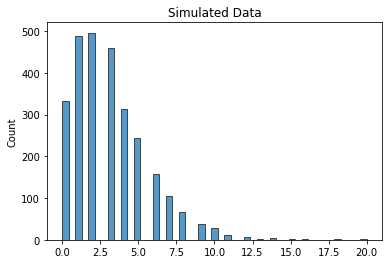

In [16]:
sns.histplot(adata_raw.obs_vector(gene_1))
plt.title('Experimental Data')
plt.show()

sns.histplot(adata_sim.X.T[0])
plt.title('Simulated Data')
plt.show()